# Spatial integration for oocgcm

 - **author** : Julien Le Sommer
 - **date** : May 2016
 - **context** : preparatory tests for defining oocgcm methods and objects

## 1. Prepare datasets and grids

In [1]:
# modules
from matplotlib import pyplot as plt
%matplotlib inline

import xarray as xr

from oocgcm.oceanmodels.nemo import grids
from oocgcm.core.utils import returnslice

In [2]:
# files
coordfile  = '/Users/lesommer/data/NATL60/NATL60-I/NATL60_coordinates_v4.nc'
maskfile = '/Users/lesommer/data/NATL60/NATL60-I/NATL60_v4.1_cdf_byte_mask.nc'
sigfile = "/Users/lesommer/data/NATL60/NATL60-MJM155-S/1d/2008/NATL60-MJM155_y2008m09.1d_BUOYANCYFLX.nc"
sshfile = "/Users/lesommer/data/NATL60/NATL60-MJM155-S/1d/2008/NATL60-MJM155_y2008m09d01.1d_gridT.nc"


In [3]:
# chunks
chunks = (1727,2711)
xr_chunks = {'x': chunks[-1], 'y': chunks[-2]}
xr_chunks_t = {'x': chunks[-1], 'y': chunks[-2],'time_counter':1}

In [4]:
# arrays
_sig = xr.open_dataset(sigfile,chunks=xr_chunks,lock=False)['vosigma0']
_ssh = xr.open_dataset(sshfile,chunks=xr_chunks,lock=False)['sossheig']

In [5]:
#- creating the grid object
_grd = grids.nemo_2d_grid(nemo_coordinate_file=coordfile,nemo_byte_mask_file=maskfile,chunks=xr_chunks)

In [6]:
#- restrict to a zone 
zone = returnslice[...,500:1500,1500:2500]
ssh = _ssh[zone]
sig = _sig[zone]
grd = _grd[zone]

/Users/lesommer/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


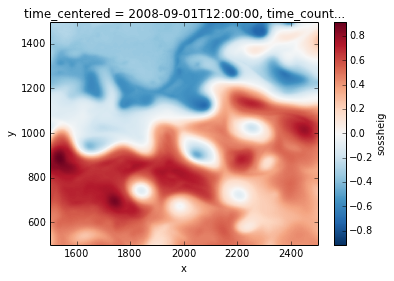

In [7]:
ssh.plot()

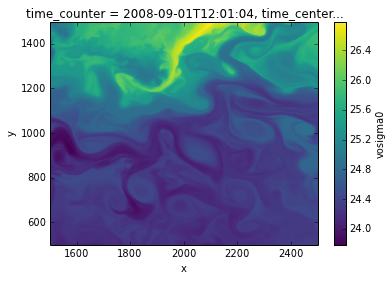

In [8]:
sig[0].plot()

## 2. Perform some tests

### First start with masks and data with simular shape, at a given moment

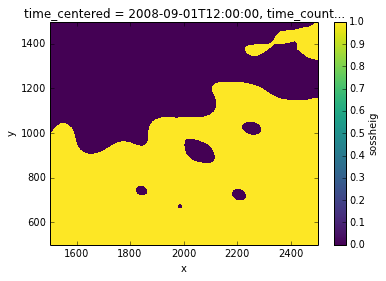

In [9]:
#- defines a mask 
condition = ssh>0.
condition.plot()

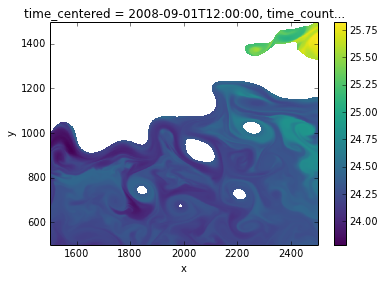

In [10]:
sig[0].where(condition).plot()

In [11]:
dxdy = grd.arrays['cell_area_at_t_location']
sig0_dxdy = sig[0].where(condition) * dxdy
average = (sig0_dxdy.sum() / dxdy.sum() )
average.to_masked_array()

masked_array(data = 15.0677587857,
             mask = False,
       fill_value = 1e+20)

**conclusion** : works fine, seems efficient enough

### Second, testing a time dependent condition with a time-dependant array 

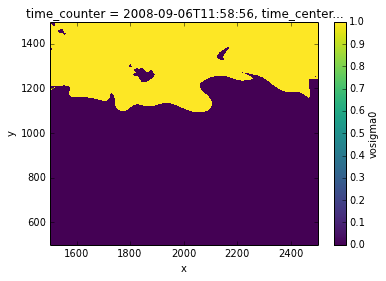

In [12]:
#- defines a time-dependant mask 
condition = sig>25.
condition[5].plot()

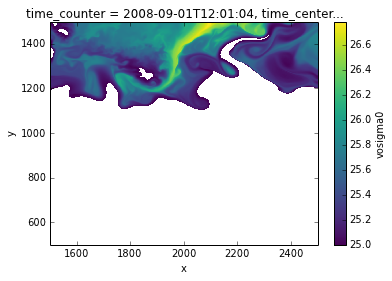

In [13]:
sig.where(condition)[0].plot()

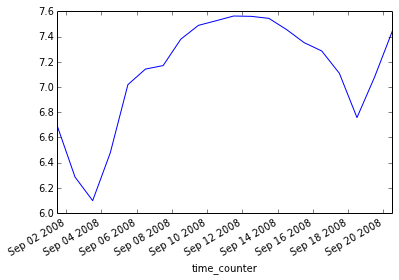

In [14]:
dxdy = grd.arrays['cell_area_at_t_location']
sig_dxdy = sig.where(condition) * dxdy
intdim = ('x','y')
average = (sig_dxdy.sum(dim=intdim) / dxdy.sum(dim=intdim) )
average[0:20].plot()

**conlusion** : works fine, building the condition seems a bit slow. 

### Third, testing a fixed condition but a time-dependant array

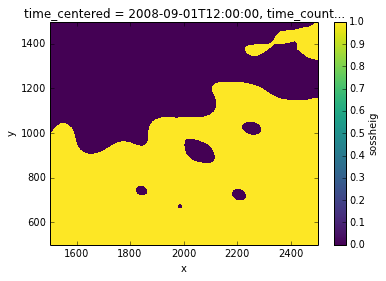

In [15]:
#- defines a mask 
condition = (ssh>0.).squeeze()
condition.plot()

In [16]:
condition.shape

(1000, 1000)

In [17]:
sig.shape

(30, 1000, 1000)

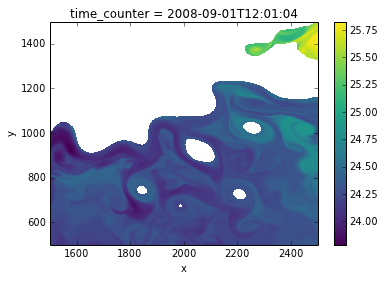

In [18]:
sig.where(condition)[0].plot()

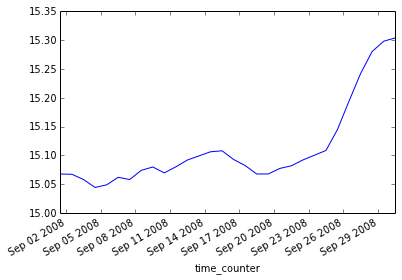

In [19]:
dxdy = grd.arrays['cell_area_at_t_location']
sig_dxdy = sig.where(condition) * dxdy
intdim = ('x','y')
average = (sig_dxdy.sum(dim=intdim) / dxdy.sum(dim=intdim) )
average.plot()

**conlusion** : works fine too, provided the condition is squeezed()

## 3. Wraps a method for oocgcm

In [24]:
from oocgcm.core.grids import check_input_array


def integrate_dxdy(self,array,where=None,grid_location=None,normalize=False):
    """Return the integral of array in regions where where is True. 
    
    Parameters
    ----------
    array : xarray.DataArray
        a dataarray with an additonal attribute specifying the grid_location.
        The dimension of array should include 'x' and 'y'. The shape of array
        should match the shape of the grid descriptor object. 
    where: boolean xarray.DataArray
        a dataarray with value = True where the integration should be applied
        The dimension of where should be a subset of the dimension of array.
        For each dimension, the size should be equal to the corresponding size
        for array dataarray.
        if where is None, the function return the integral in all the domain 
        defined by the grid object. 
    grid_location : str
        string describing the grid location : eg 'u','v','t','f'... 
         - if grid_location is not None
                check compatibility with array.attrs.grid_location
         - if grid_location is None
                use array.attrs.grid_location by default
    normalize    
        
    Returns
    -------
    integral: xarray.DataArray
        a dataarray with reduced dimension defining the integral of array in 
        the region of interest. 
    """
    # check grid location
    if grid_location is None:
        if not(isinstance(array,xr.DataArray)):
            raise TypeError('input array should be a xarray.DataArray')
        elif array.attrs.has_key("grid_location"):
            grid_location = array.attrs["grid_location"]
        else:
            raise Exception('grid_location is not known.')
        #except:
        #    raise TypeError('input array should be a xarray.DataArray')   
        
    # check arrays 
    check_input_array(array,\
                        chunks=self.chunks,grid_location=grid_location,
                        ndims=self.ndims)
    if where is not None:
        check_input_array(where,\
                          chunks=self.chunks,grid_location=grid_location,
                          ndims=self.ndims)
    else:
        maskname = "sea_binary_mask_at_" + grid_location + "_location"
        where = self.arrays[maskname]
        
    # actual definition
    idims = ('x','y')
    dxdy = grd.arrays['cell_area_at_' + grid_location + '_location']
    array_dxdy = array.where(where.squeeze()) * dxdy
    integral = array_dxdy.sum(dim=idims)
    
    # normalize if required
    if normalize:
        integral /= dxdy.where(where.squeeze()).sum(dim=intdim)
    
    return integral

def average_dxdy(self,array,where=None,grid_location=None):
    """Return the average of array in regions where where is True. 
    
    Parameters
    ----------
    array : xarray.DataArray
        a dataarray with an additonal attribute specifying the grid_location.
        The dimension of array should include 'x' and 'y'. The shape of array
        should match the shape of the grid descriptor object. 
    where: boolean xarray.DataArray
        a dataarray with value = True where the integration should be applied
        The dimension of where should be a subset of the dimension of array.
        For each dimension, the size should be equal to the corresponding size
        for array dataarray.
        if where is None, the function return the integral in all the domain 
        defined by the grid object. 
    grid_location : str
        string describing the grid location : eg 'u','v','t','f'... 
         - if grid_location is not None
                check compatibility with array.attrs.grid_location
         - if grid_location is None
                use array.attrs.grid_location by default
        
    Returns
    -------
    average: xarray.DataArray
        a dataarray with reduced dimension defining the average of array in 
        the region of interest. 
    """

    average = integrate_dxdy(self,array,where=where,grid_location=grid_location,normalize=True)    
    return average

## 4. Testing the new tool

24.3076667397


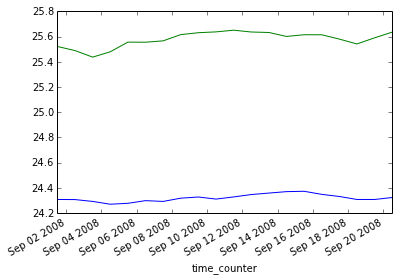

In [25]:
#- constant condition / constant array
condition = ssh>0.
ave = average_dxdy(grd,sig[0],where=condition,grid_location='t')
print ave.values

#- constant condition/varying array
condition = (ssh>0.).squeeze()
ave = average_dxdy(grd,sig,where=condition,grid_location='t')
ave[0:20].plot()

#- time-dependant condition
condition = sig>25.
ave = average_dxdy(grd,sig,where=condition,grid_location='t')
ave[0:20].plot()

In [23]:
#- testing bad calls
condition = ssh>0.
sig.attrs['grid_location'] = 't'
ave = average_dxdy(grd,sig[0],where=None,grid_location=None)
print ave.values

t
24.6528144323


In [ ]:
ave.attrs.

## 5. Conclusion for oocgcm design

Ready for implementation. 
 - intensive scalar variables : integrate_dx, integrate_dy, integrate_dxdy

Needs further thinking : 
 - vector fields : flux across a contour. requires a definition of contours of f-points. 
 - countour = tuples of indices a la PyDom ? 
